In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
import sys

assert sys.version_info >= (3, 7)
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium
    %pip install -q -U gymnasium[classic_control,atari,accept-rom-license]
    %pip install -q -U minatar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 16.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.7 MB/s eta 0:00:00


In [ ]:
import copy
import math
import os
from collections import namedtuple
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from IPython.display import display, clear_output
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]
from tqdm import trange
import gymnasium
import gym
import pickle

In [ ]:
envs = {'Breakout':gymnasium.make('MinAtar/Breakout-v1',render_mode = 'rgb_array')}

In [ ]:
checkpoint = torch.load(f'checkpoint_breakout_DDQN.pt')

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # get the size of the flattened tensor
        self.flatten_size = self._get_flatten_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def _get_flatten_size(self):
        dummy_input = torch.zeros(1, 4, 10, 10)  # input size is (batch_size, channels, height, width)
        dummy_output = self._forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def _forward_conv(self, states):
        x = F.relu(self.conv1(states))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        return x


    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # use the defined layers and activations to compute
        # the action-values tensor associated with the input states.

        x = F.relu(self.conv1(states))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten output for fully connected layers
        x = x.reshape(-1, self.flatten_size)

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


    def get_conv_out_size(self, shape):
        # Calculate the output size after convolution
        dummy_input = torch.zeros(1, *shape)
        dummy_output = self.conv_seq(dummy_input)
        return dummy_output.view(1, -1).size(1)

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# test code


def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )


# Smoothing Function

In [ ]:
def rolling_average(data, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

# Load Pickle Files

In [ ]:
with open('returns_r2_DQN.pkl', 'rb') as fp:
    DQN_returns = pickle.load(fp)

with open('losses_r2_DQN.pkl', 'rb') as fp:
    DQN_losses = pickle.load(fp)

with open('lengths_r2_DQN.pkl', 'rb') as fp:
    DQN_lengths = pickle.load(fp)

with open('q_r2_DQN.pkl', 'rb') as fp:
    DQN_q = pickle.load(fp)

with open('next_q_r2_DQN.pkl', 'rb') as fp:
    DQN_next_q = pickle.load(fp)

with open('tot_actions_r2_DQN.pkl', 'rb') as fp:
    DQN_tot_actions = pickle.load(fp)


#DDQN Files
with open('returns_DDQN.pkl', 'rb') as fp:
    DDQN_returns = pickle.load(fp)

with open('losses_DDQN.pkl', 'rb') as fp:
    DDQN_losses = pickle.load(fp)

with open('lengths_DDQN.pkl', 'rb') as fp:
    DDQN_lengths = pickle.load(fp)

with open('q_DDQN.pkl', 'rb') as fp:
    DDQN_q = pickle.load(fp)

with open('next_q_DDQN.pkl', 'rb') as fp:
    DDQN_next_q = pickle.load(fp)

with open('tot_actions_DDQN.pkl', 'rb') as fp:
    DDQN_tot_actions = pickle.load(fp)

#Visualizations

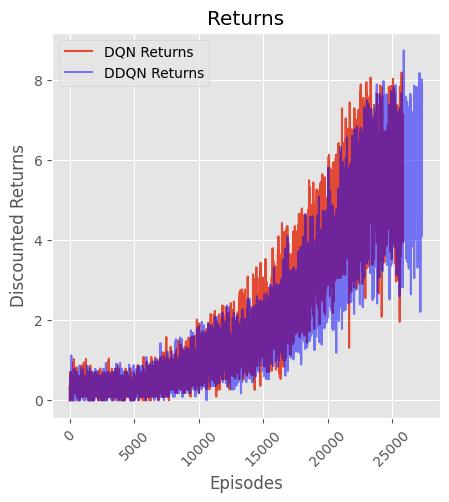

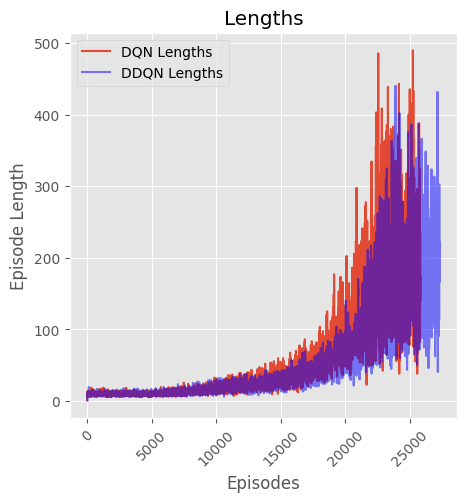

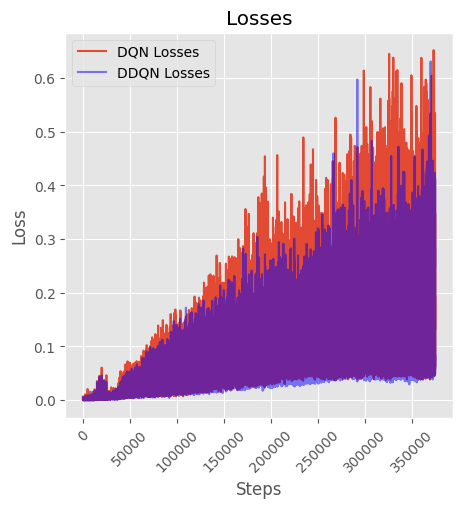

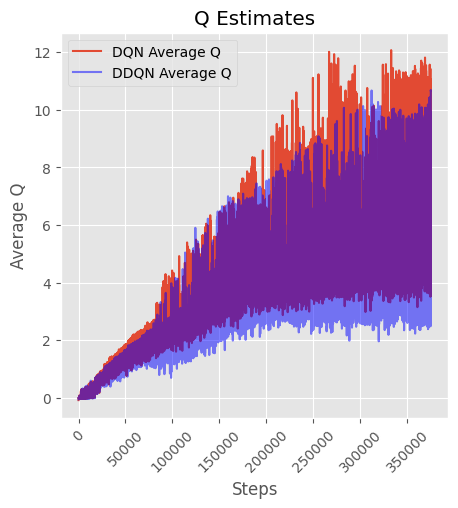

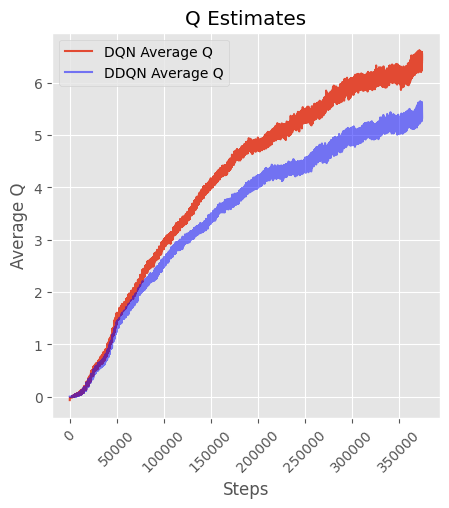

In [ ]:
#smooth returns
window_size = 10
smooth_returns_DQN = rolling_average(DQN_returns,window_size)
smooth_lengths_DQN = rolling_average(DQN_lengths,window_size)
smooth_losses_DQN = rolling_average(DQN_losses,window_size)
smooth_q_DQN = rolling_average(DQN_q,window_size)
smooth_next_q_DQN = rolling_average(DQN_next_q,window_size)

smooth_returns_DDQN = rolling_average(DDQN_returns,window_size)
smooth_lengths_DDQN = rolling_average(DDQN_lengths,window_size)
smooth_losses_DDQN = rolling_average(DDQN_losses,window_size)
smooth_q_DDQN = rolling_average(DDQN_q,window_size)
smooth_next_q_DDQN = rolling_average(DDQN_next_q,window_size)

#Returns
plt.figure(figsize=(5, 5))
plt.plot(smooth_returns_DQN, label='DQN Returns')
plt.plot(smooth_returns_DDQN, label='DDQN Returns', color='blue', alpha = 0.5)
plt.xlabel('Episodes')
plt.xticks(rotation=45)
plt.ylabel('Discounted Returns')
plt.title('Returns')
plt.legend()
plt.show()

# Lengths
plt.figure(figsize=(5, 5))
plt.plot(smooth_lengths_DQN, label='DQN Lengths', )
plt.plot(smooth_lengths_DDQN, label='DDQN Lengths', color='blue',alpha=0.5)
plt.xlabel('Episodes')
plt.xticks(rotation=45)
plt.ylabel('Episode Length')
plt.title('Lengths')
plt.legend()
plt.show()

#Losses
plt.figure(figsize=(5, 5))
plt.plot(smooth_losses_DQN, label='DQN Losses', )
plt.plot(smooth_losses_DDQN, label='DDQN Losses', color='blue',alpha=0.5)
plt.xlabel('Steps')
plt.xticks(rotation=45)
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.show()

# Average Q
plt.figure(figsize=(5, 5))
plt.plot(smooth_q_DQN, label='DQN Average Q', )
plt.plot(smooth_q_DDQN, label='DDQN Average Q', color='blue',alpha=0.5)
plt.xlabel('Steps')
plt.xticks(rotation=45)
plt.ylabel('Average Q')
plt.title('Q Estimates')
plt.legend()
plt.show()

#Average Next Q
plt.figure(figsize=(5, 5))
plt.plot(smooth_next_q_DQN, label='DQN Average Q', )
plt.plot(smooth_next_q_DDQN, label='DDQN Average Q', color='blue',alpha=0.5)
plt.xlabel('Steps')
plt.xticks(rotation=45)
plt.ylabel('Average Q')
plt.title('Q Estimates')
plt.legend()
plt.show()

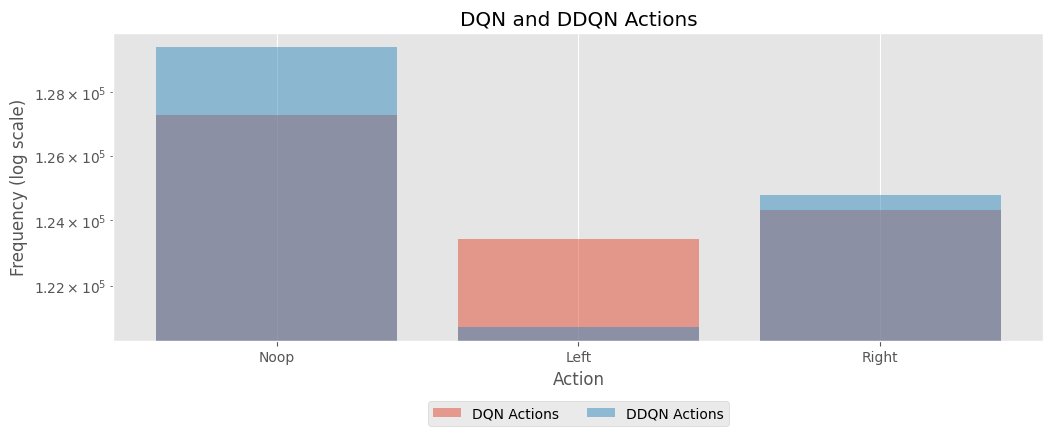

In [ ]:
dqn_values, dqn_counts = np.unique(DQN_tot_actions, return_counts=True)
ddqn_values, ddqn_counts = np.unique(DDQN_tot_actions, return_counts=True)

# Map actions to values
action_mapping = {0: 'Noop',  1: 'Left',  2: 'Right'}


dqn_quantitative_values = np.array([action_mapping[action] for action in dqn_values])

# DQN Bar plot
plt.bar(dqn_quantitative_values, dqn_counts, alpha=0.5, label='DQN Actions')

# DDQN Bar plot
plt.bar(ddqn_values, ddqn_counts, alpha=0.5, label='DDQN Actions')

# labels and title
plt.xlabel('Action')
plt.ylabel('Frequency (log scale)')
plt.title('DQN and DDQN Actions')

# legend
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.yscale('log')
plt.show()